<a href="https://colab.research.google.com/github/Nik-Kras/ToMnet-N/blob/main/Draw_ToMnet_N.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sub-Class Layers

In [124]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
class CharNet(nnl.NeuralNetLayers):

For the single trajectory τi in the past episode, the
ToMnet forms the character embedding echar,i as follows. We
 (1) pre-process the data from each time-step by spatialising the actions,
 a(obs), concatenating these with the respective states, x(obs),
 (2) passing through a 5-layer resnet, with 32 channels, ReLU nonlinearities,
 and batch-norm, followed by average pooling.
 (3) We pass the results through an LSTM with 64 channels,
 with a linear output to either a 2-dim or 8-dim echar,i (no substantial difference in results).
@author: Chuang, Yun-Shiuan; Edwinn
"""

import tensorflow as tf
from tensorflow import keras

from keras.models import Model
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import TimeDistributed
from keras.layers import BatchNormalization
from keras.layers import LSTM
from keras import activations

class CustomCnn(keras.layers.Layer):
    def __init__(self, input_tensor=None, activation="linear", filters=64, UseTimeWrapper=False,  **kwargs):
        super(CustomCnn, self).__init__(**kwargs)
        self.input_tensor = input_tensor
        self.activation = activation
        self.filters = filters
        if input_tensor is None:
          self.conv = tf.keras.layers.Conv2D(filters=filters,
                                  kernel_size=(3, 3),
                                  strides=(1, 1),
                                  activation=activation,
                                  padding="same")
        else:
          self.conv = tf.keras.layers.Conv2D(filters=filters,
                                  kernel_size=(3, 3),
                                  strides=(1, 1),
                                  activation=activation,
                                  padding="same",
                                  input_shape=input_tensor)
        if UseTimeWrapper: self.conv_handler = tf.keras.layers.TimeDistributed(self.conv)
        self.UseTimeWrapper = UseTimeWrapper


    def call(self, inputs):
      if self.UseTimeWrapper: x = self.conv_handler(inputs)
      else: x = self.conv(inputs)

      return x

    def get_config(self):
      config = super().get_config()
      config.update({
          "input_tensor": self.input_tensor,
          "activation": self.activation,
          "filters": self.filters,
          "UseTimeWrapper": self.UseTimeWrapper
      })
      return config

def CustomCnnCharNet(input_tensor=None, activation="linear", filters=64, **kwargs):
    return CustomCnn(input_tensor=input_tensor, activation=activation, filters=filters, UseTimeWrapper=True, **kwargs)

def CustomCnnPredNet(input_tensor=None, activation="linear", filters=64, **kwargs):
    return CustomCnn(input_tensor=input_tensor, activation=activation, filters=filters, UseTimeWrapper=False, **kwargs)

class ResBlock(keras.layers.Layer):
    def __init__(self, UseTimeWrapper=False, **kwargs):
        super(ResBlock, self).__init__(**kwargs)
        if UseTimeWrapper:
            self.conv1 = CustomCnnCharNet(activation="relu")
            # Use Batch Normalisation and then Relu activation in future!
            self.conv2 = CustomCnnCharNet(activation="linear")
            # Use Batch Normalisation in future!
        else:
            self.conv1 = CustomCnnPredNet(activation="relu")
            # Use Batch Normalisation and then Relu activation in future!
            self.conv2 = CustomCnnPredNet(activation="linear")
            # Use Batch Normalisation in future!
        self.UseTimeWrapper = UseTimeWrapper

    def call(self, inputs):
        x = self.conv1(inputs)
        x = self.conv2(x)
        x = tf.nn.relu(x + inputs)
        return x

    def get_config(self):
      config = super().get_config()
      config.update({
          "UseTimeWrapper": self.UseTimeWrapper
      })
      return config

def ResBlockCharNet(**kwargs):
    return ResBlock(UseTimeWrapper=True, **kwargs)

def ResBlockPredNet(**kwargs):
    return ResBlock(UseTimeWrapper=False, **kwargs)

class CustomLSTM(keras.layers.Layer):
  def __init__(self, num_hidden = 128, output_keep_prob = 0.2, **kwargs):
    super(CustomLSTM, self).__init__(**kwargs)
    self.num_hidden = num_hidden
    self.output_keep_prob = output_keep_prob
    self.lstm = LSTM(units=num_hidden,
                    activation = activations.tanh,
                    recurrent_activation = activations.sigmoid)
    self.bn = BatchNormalization()

  def call(self, inputs):
    x = self.lstm(inputs)
    x = self.bn(x)
    return x

  def get_config(self):
    config = super().get_config()
    config.update({
        "output_keep_prob": self.output_keep_prob,
        "num_hidden": self.num_hidden
    })
    return config

## Additional Layers for drawing

In [125]:
class ManyResBlocksCharNet(keras.layers.Layer):
    def __init__(self, UseTimeWrapper=False, n=32, filters=64, **kwargs):
        super(ResBlock, self).__init__(**kwargs)
        self.n = n
        self.res_blocks = [None] * n
        for i in range(n):
            self.res_blocks[i] = ResBlockCharNet(filters=filters)

    def call(self, inputs):
        x = self.res_blocks[0](inputs)
        for i in range(1, self.n):
            x = self.res_blocks[i](x) 
        return x

    def get_config(self):
      config = super().get_config().copy()
      config.update({
          "n": self.n,
          "filters": self.filters
      })
      return config

class ManyResBlocksPredNet(keras.layers.Layer):
  def __init__(self, UseTimeWrapper=False, n=32, filters=64, **kwargs):
      super(ResBlock, self).__init__(**kwargs)
      self.n = n
      self.res_blocks = [None] * n
      for i in range(n):
          self.res_blocks[i] = ResBlockPredNet(filters=filters)

  def call(self, inputs):
      x = self.res_blocks[0](inputs)
      for i in range(1, self.n):
          x = self.res_blocks[i](x) 
      return x

  def get_config(self):
    config = super().get_config().copy()
    config.update({
        "n": self.n,
        "filters": self.filters
    })
    return config

# Sub-class Models

In [126]:
# --------------------------------------------------------------
# CharNet is a layer, as it doesn't have separate and own training,
# it is simply a part of whole network, so can be considered as a layer
# --------------------------------------------------------------
class CharNet(keras.layers.Layer):

    def __init__(self, input_tensor, n, N_echar):
        super(CharNet, self).__init__()

        # self.input_tensor = input_tensor
        self.n = n
        self.N_echar = N_echar

        self.conv = CustomCnnCharNet(input_tensor=input_tensor)
        self.res_blocks = [None] * n
        for i in range(n):
          self.res_blocks[i] = ResBlockCharNet()
        # Global Pool
        self.lstm = CustomLSTM()
        self.e_char = Dense(N_echar)
        

    def call(self, inputs):
        """
        Build the character net.
        """

        # input_tensor = self.input_tensor
        n = self.n
        N_echar = self.N_echar

        batch_size, trajectory_size, height, width, depth  = inputs.get_shape().as_list()

        # --------------------------------------------------------------
        # Paper codes
        # (16, 10, 12, 12, 11) -> (16, 10, 12, 12, 32)
        # Add initial Conv2D layer
        # Conv2D standard: Shape = (batch_size, width, height, channels)
        # Conv2D takes only width x height x channels (12, 12, 11)
        # Time Distributed layer feeds a Conv2D with time-frames (10 frames)
        # That process is happening in parallel for 16 objects in one batch
        # --------------------------------------------------------------
        x = self.conv(inputs)

        # --------------------------------------------------------------
        # Paper codes
        # (16, 10, 12, 12, 11) -> (16, 10, 12, 12, 32)
        # Add n residual layers
        # Conv2D takes only width x height x channels (12, 12, 11)
        # Time Distributed layer feeds a Conv2D with time-frames (10 frames)
        # That process is happening in parallel for 16 objects in one batch
        # --------------------------------------------------------------
        for i in range(n):
          x = self.res_blocks[i](x)    ### Possible error here!!!
            
        # --------------------------------------------------------------
        # Paper codes
        # (16, 10, 12, 12, 32) ->  (16, 10, 32)
        # Add average pooling
        # Collapse the spatial dimensions
        # --------------------------------------------------------------
        x = tf.reduce_mean(input_tensor=x, axis=[2, 3])

        # --------------------------------------------------------------
        # Paper codes
        # (16, 10, 32) ->  (16, 64)
        # Add LSTM
        # Standard: Shape = (batch_size, time_step, features)
        # for each x_i(t)(example_i's step_t): a (64, 1) = W(64, 32) * x (32, 1)
        # --------------------------------------------------------------
        x = self.lstm(x)

        # --------------------------------------------------------------
        # Paper codes
        # (16, 64) -> (16, 4)
        # Add Fully connected layer
        # (batch_size, features) - > (batch_size, e_char)
        # --------------------------------------------------------------
        x = self.e_char(x)

        return x

Testing CharNet:

In [127]:
c = CharNet((10, 12, 12, 11), 8, 8)

In [128]:
dummy_data_1 = tf.ones((16, 10, 12, 12, 11))
print(dummy_data_1.shape)

(16, 10, 12, 12, 11)


In [129]:
print(c.call(dummy_data_1)[:, 1])

tf.Tensor(
[-0.0600077 -0.0600077 -0.0600077 -0.0600077 -0.0600077 -0.0600077
 -0.0600077 -0.0600077 -0.0600077 -0.0600077 -0.0600077 -0.0600077
 -0.0600077 -0.0600077 -0.0600077 -0.0600077], shape=(16,), dtype=float32)


In [130]:
# --------------------------------------------------------------
# PredNet is a layer, as it doesn't have separate and own training,
# it is simply a part of whole network, so can be considered as a layer
# --------------------------------------------------------------
class PredNet(keras.layers.Layer):

    def __init__(self, n):
        super(PredNet, self).__init__()
        self.n = n

        self.e_char_shape = 8
        self.current_state_shape = (12, 12, 6)

        self.conv_1 = CustomCnnPredNet(input_tensor=self.current_state_shape)
        self.res_blocks = [None] * n
        for i in range(n):
          self.res_blocks[i] = ResBlockPredNet()
        self.conv_2 = CustomCnnPredNet(activation='relu')
        self.fc1 = Dense(units=128, activation=activations.relu)
        self.fc2 = Dense(units=128, activation=activations.relu)
        self.fc3 = Dense(units=64, activation=activations.relu)
        # drop_out_1 = Dropout(rate = 0.2) ### Could be added in the future
        self.goal_predict = Dense(units=4, activation=activations.linear)

    def call(self, inputs):
        """
        Build the character net.
        """
        ### Check that inputs.shape == (None, 13, 12, 8)

        # Get shapes
        # batch_size, height, width, depth = inputs.get_shape().as_list()
        # _, embedding_length = e_char.get_shape().as_list()
        n = self.n

        # --------------------------------------------------------------
        # Paper codes
        # (16, 13, 12, 8) -> (16, 12, 12, 6) + (16, 8)
        # Decompose input data
        # Initially in is a mix of Current State and e_char embedding space
        # --------------------------------------------------------------
        input_current_state = inputs[..., 0:12, 0:12, 0:6]
        e_char = inputs[..., 12, 0, :]

        # --------------------------------------------------------------
        # Paper codes
        # (16, 12, 12, 6) -> (16, 12, 12, 32)
        # Use 3x3 conv layer to shape the depth to 32
        # to enable resnet to work (addition between main path and residual connection)
        # --------------------------------------------------------------
        x = self.conv_1(input_current_state)

        # --------------------------------------------------------------
        # Paper codes
        # (16, 12, 12, 32) -> (16, 12, 12, 32)
        # Add n residual layers
        # Conv2D takes only width x height x channels (12, 12, 11)
        # Time Distributed layer feeds a Conv2D with time-frames (10 frames)
        # That process is happening in parallel for 16 objects in one batch
        # --------------------------------------------------------------
        for i in range(n):
          x = self.res_blocks[i](x)    ### Possible error here!!!

        # --------------------------------------------------------------
        # Paper codes
        # (16, 12, 12, 32) -> (16, 12, 12, 32)
        # Add CNN after Res Blocks
        # --------------------------------------------------------------
        x = self.conv_2(x)

        # --------------------------------------------------------------
        # Paper codes
        # (16, 12, 12, 32) -> (16, 32)
        # Add average pooling
        # Collapse the spatial dimensions
        # --------------------------------------------------------------
        x = tf.reduce_mean(input_tensor=x, axis=[1, 2])

        # --------------------------------------------------------------
        # Paper codes
        # (16, 32) + (16, 8) -> (16, 32, 1) + (16, 8, 1) - > 
        # (16, 40, 1) -> (16, 40)
        # Concatenate tensor with e_char
        # Concatenation requires a common dimentions which cannot be a batch
        # --------------------------------------------------------------
        x = tf.expand_dims(x, axis=-1)
        e_char = tf.expand_dims(e_char, axis=-1)

        x = tf.keras.layers.Concatenate(axis=1)([x, e_char])
        x = x[..., 0]

        # --------------------------------------------------------------
        # Paper codes
        # (16, 40) -> (16, 60) -> (16, 4)
        # Fully connected layer with dropout for regularization
        # --------------------------------------------------------------
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        x = self.goal_predict(x)

        return x

Test Pred Net

In [131]:
dummy_data_1 = tf.ones((16, 13, 12, 8))
print(dummy_data_1.shape)

(16, 13, 12, 8)


In [132]:
pred_net = PredNet(5)
print(pred_net.call(dummy_data_1)[:, 1])

tf.Tensor(
[0.09811288 0.09811288 0.09811288 0.09811288 0.09811288 0.09811288
 0.09811288 0.09811288 0.09811288 0.09811288 0.09811288 0.09811288
 0.09811288 0.09811288 0.09811288 0.09811288], shape=(16,), dtype=float32)


## Define ToMnet-N

In [133]:
# --------------------------------------
# ToMnet-N represents the model itself
# --------------------------------------
from keras import Model

class ToMnet_N(Model):

    BATCH_SIZE = 16
    TRAJECTORY_SHAPE = (10, 12, 12, 11)
    CURRENT_STATE_SHAPE = (12, 12, 6)

    LENGTH_E_CHAR = 8
    NUM_RESIDUAL_BLOCKS = 8

    TRAIN_EMA_DECAY = 0.95
    INIT_LR = 0.0001


    def __init__(self):
        super(ToMnet_N, self).__init__(name="ToMnet-N")

        # Create the model
        self.char_net = CharNet(input_tensor=self.TRAJECTORY_SHAPE,
                              n=self.NUM_RESIDUAL_BLOCKS,
                              N_echar=self.LENGTH_E_CHAR)

        self.pred_net = PredNet(n=self.NUM_RESIDUAL_BLOCKS)

        # Set compilers / savers / loggers / callbacks


    def call(self, inputs):
        input_trajectory = inputs[..., 0:10, :, :, :]
        input_current_state = inputs[..., 10, :, :, 0:6]

        e_char = self.char_net(input_trajectory)

        print("In ToMnet-N: ")
        print("input_trajectory: ", input_trajectory.shape)
        print("input_current_state: ", input_current_state.shape)
        print("e_char: ", e_char.shape)

        # --------------------------------------------------------------
        # Paper codes
        # (16, 12, 12, 6) + (16, 8) -> 
        # (16, 12, 12, 8) + (16, 1, 12, 8) -> (16, 13, 12, 8)
        # Spatialise and unite different data into one tensor
        # They are automatically decompose in the Pred Net to different data
        # --------------------------------------------------------------
        input_current_state = tf.repeat(input_current_state, repeats=2, axis=-1)
        input_current_state = input_current_state[..., 0:8]
        print("input_current_state: ", input_current_state.shape)
    
        e_char =  tf.expand_dims(e_char, axis=1)
        print("e_char: ", e_char.shape)
        e_char =  tf.expand_dims(e_char, axis=1)
        print("e_char: ", e_char.shape)
        e_char = tf.repeat(e_char, repeats=12, axis=2)
        print("e_char: ", e_char.shape)

        mix_data = tf.keras.layers.Concatenate(axis=1)([input_current_state, e_char])

        print("pred input: ", mix_data.shape)

        pred = self.pred_net(mix_data)
        output = pred
        return output


    ### This is a trick to view shapes in summary() via
    ### model.model().summary()
    def model(self):
        x = tf.keras.Input(shape=(11, 12, 12, 11))
        return tf.keras.Model(inputs=[x], outputs=self.call(x))

## Test ToMnet-N

In [134]:
dummy_data_1 = tf.ones((10, 12, 12, 11))
dummy_data_2 = tf.ones((12, 12, 6))

dummy_data_3 = tf.zeros((12, 12, 5))

dummy_data_2_u  = tf.concat([dummy_data_2, dummy_data_3], -1)

dummy_data_2_uu = tf.expand_dims(dummy_data_2_u, 0)

combined_data = tf.concat([dummy_data_1, dummy_data_2_uu], axis=0)


print("Shape data 1: ", dummy_data_1.shape)
print("Shape data 2: ", dummy_data_2.shape)
print("Shape data 3: ", dummy_data_3.shape)
print("Shape data 2 updated: ", dummy_data_2_u.shape)
print("Shape data 2 updated twice: ", dummy_data_2_uu.shape)
print("Output shape: ", combined_data.shape)

Shape data 1:  (10, 12, 12, 11)
Shape data 2:  (12, 12, 6)
Shape data 3:  (12, 12, 5)
Shape data 2 updated:  (12, 12, 11)
Shape data 2 updated twice:  (1, 12, 12, 11)
Output shape:  (11, 12, 12, 11)


In [135]:
dummy_data_1 = tf.ones((10, 12, 12, 11))
dummy_data_2 = tf.ones((12, 12, 6))

dummy_data_3 = tf.expand_dims(dummy_data_2, axis=0)

dummy_data_4 = tf.repeat(dummy_data_3, repeats=2, axis=-1)[:,:,:,0:11]

dummy_combined = tf.keras.layers.Concatenate(axis=0)([dummy_data_1, dummy_data_4])

print("Shape data 1: ", dummy_data_1.shape)
print("Shape data 2: ", dummy_data_2.shape)
print("Shape data 3: ", dummy_data_3.shape)
print("Shape data 4: ", dummy_data_4.shape)
print("Combination: ", dummy_combined.shape)

Shape data 1:  (10, 12, 12, 11)
Shape data 2:  (12, 12, 6)
Shape data 3:  (1, 12, 12, 6)
Shape data 4:  (1, 12, 12, 11)
Combination:  (11, 12, 12, 11)


In [136]:
# Add batch size!
dummy_combined =  tf.expand_dims(dummy_combined, axis=0)
dummy_combined = tf.repeat(dummy_combined, repeats=16, axis = 0)

print(dummy_combined.shape)

(16, 11, 12, 12, 11)


In [137]:
ToMnet_N = ToMnet_N()
print(ToMnet_N.predict(dummy_combined)[0, :])

In ToMnet-N: 
input_trajectory:  (None, 10, 12, 12, 11)
input_current_state:  (None, 12, 12, 6)
e_char:  (None, 8)
input_current_state:  (None, 12, 12, 8)
e_char:  (None, 1, 8)
e_char:  (None, 1, 1, 8)
e_char:  (None, 1, 12, 8)
pred input:  (None, 13, 12, 8)
In ToMnet-N: 
input_trajectory:  (None, 10, 12, 12, 11)
input_current_state:  (None, 12, 12, 6)
e_char:  (None, 8)
input_current_state:  (None, 12, 12, 8)
e_char:  (None, 1, 8)
e_char:  (None, 1, 1, 8)
e_char:  (None, 1, 12, 8)
pred input:  (None, 13, 12, 8)
1/1 [==============================] - 3s 3s/step
[ 0.21997651  0.53851986 -0.00545204 -0.27622908]


In [138]:
ToMnet_N.summary()

Model: "ToMnet-N"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 char_net_9 (CharNet)        multiple                  697608    
                                                                 
 pred_net_9 (PredNet)        multiple                  665668    
                                                                 
Total params: 1,363,276
Trainable params: 1,363,020
Non-trainable params: 256
_________________________________________________________________


In [139]:
ToMnet_N.model().summary()

In ToMnet-N: 
input_trajectory:  (None, 10, 12, 12, 11)
input_current_state:  (None, 12, 12, 6)
e_char:  (None, 8)
input_current_state:  (None, 12, 12, 8)
e_char:  (None, 1, 8)
e_char:  (None, 1, 1, 8)
e_char:  (None, 1, 12, 8)
pred input:  (None, 13, 12, 8)
Model: "model_15"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_16 (InputLayer)          [(None, 11, 12, 12,  0           []                               
                                 11)]                                                             
                                                                                                  
 tf.__operators__.getitem_36 (S  (None, 10, 12, 12,   0          ['input_16[0][0]']               
 licingOpLambda)                11)                                                               
                              

In [140]:
!pip install git+https://github.com/paulgavrikov/visualkeras --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/paulgavrikov/visualkeras to /tmp/pip-req-build-v44ukpdd
  Running command git clone -q https://github.com/paulgavrikov/visualkeras /tmp/pip-req-build-v44ukpdd


# Define same models for drawing

## Define ToMnet-N for plot


In [141]:
#### ToMnet_N_for_plot
class ToMnet_N_for_plot(Model):

    BATCH_SIZE = 16
    TRAJECTORY_SHAPE = (10, 12, 12, 11)
    CURRENT_STATE_SHAPE = (12, 12, 6)

    LENGTH_E_CHAR = 8
    NUM_RESIDUAL_BLOCKS = 5

    TRAIN_EMA_DECAY = 0.95
    INIT_LR = 0.0001


    def __init__(self):
        super(ToMnet_N_for_plot, self).__init__(name="ToMnet-N")

        self.n = self.NUM_RESIDUAL_BLOCKS

        # Create the model
        self.E_N_echar = self.LENGTH_E_CHAR

        self.E_conv = CustomCnnCharNet(input_tensor=self.TRAJECTORY_SHAPE)
        self.E_res_blocks = [None] * self.NUM_RESIDUAL_BLOCKS
        for i in range(self.NUM_RESIDUAL_BLOCKS):
          self.E_res_blocks[i] = ResBlockCharNet()
        # Global Pool
        self.E_lstm = CustomLSTM()
        self.E_e_char = Dense(self.LENGTH_E_CHAR)

        self.P_conv_1 = CustomCnnPredNet(input_tensor=self.CURRENT_STATE_SHAPE)
        self.P_res_blocks = [None] * self.NUM_RESIDUAL_BLOCKS
        for i in range(self.NUM_RESIDUAL_BLOCKS):
          self.P_res_blocks[i] = ResBlockPredNet()
        self.P_conv_2 = CustomCnnPredNet(activation='relu')
        self.P_fc = Dense(units=60, activation=activations.relu)
        self.P_goal_predict = Dense(units=4, activation=activations.linear)

        # Set compilers / savers / loggers / callbacks


    def call(self, inputs):
        input_trajectory = inputs[..., 0:10, :, :, :]
        input_current_state = inputs[..., 10, :, :, 0:6]

        # input_tensor = self.input_tensor
        n = self.n

        #batch_size, trajectory_size, height, width, depth  = inputs.get_shape().as_list()
        x = self.E_conv(inputs)
        for i in range(n):
          x = self.E_res_blocks[i](x)    ### Possible error here!!!
        x = tf.reduce_mean(input_tensor=x, axis=[2, 3])
        x = self.E_lstm(x)
        x = self.E_e_char(x)

        e_char = x

        x = self.P_conv_1(input_current_state)
        for i in range(n):
          x = self.P_res_blocks[i](x)    ### Possible error here!!!
        x = self.P_conv_2(x)
        x = tf.reduce_mean(input_tensor=x, axis=[1, 2])
        x = tf.expand_dims(x, axis=-1)
        e_char = tf.expand_dims(e_char, axis=-1)
        x = tf.keras.layers.Concatenate(axis=1)([x, e_char])
        x = x[..., 0]
        x = self.P_fc(x)
        x = self.P_goal_predict(x)

        return x


    ### This is a trick to view shapes in summary() via
    ### model.model().summary()
    def model(self):
        x = tf.keras.Input(shape=(11, 12, 12, 11))
        return tf.keras.Model(inputs=[x], outputs=self.call(x))

In [142]:
plot_model = ToMnet_N_for_plot()

In [143]:
dummy_data = tf.ones((16,11,12,12,11))

In [144]:
plot_model.predict(dummy_data)

1/1 [==============================] - 3s 3s/step


array([[ 0.09320085, -0.4417887 , -0.24842441, -0.01339081],
       [ 0.09320085, -0.4417887 , -0.24842441, -0.01339081],
       [ 0.09320085, -0.4417887 , -0.24842441, -0.01339081],
       [ 0.09320085, -0.4417887 , -0.24842441, -0.01339081],
       [ 0.09320085, -0.4417887 , -0.24842441, -0.01339081],
       [ 0.09320085, -0.4417887 , -0.24842441, -0.01339081],
       [ 0.09320085, -0.4417887 , -0.24842441, -0.01339081],
       [ 0.09320085, -0.4417887 , -0.24842441, -0.01339081],
       [ 0.09320085, -0.4417887 , -0.24842441, -0.01339081],
       [ 0.09320085, -0.4417887 , -0.24842441, -0.01339081],
       [ 0.09320085, -0.4417887 , -0.24842441, -0.01339081],
       [ 0.09320085, -0.4417887 , -0.24842441, -0.01339081],
       [ 0.09320085, -0.4417887 , -0.24842441, -0.01339081],
       [ 0.09320085, -0.4417887 , -0.24842441, -0.01339081],
       [ 0.09320085, -0.4417887 , -0.24842441, -0.01339081],
       [ 0.09320085, -0.4417887 , -0.24842441, -0.01339081]],
      dtype=float32)

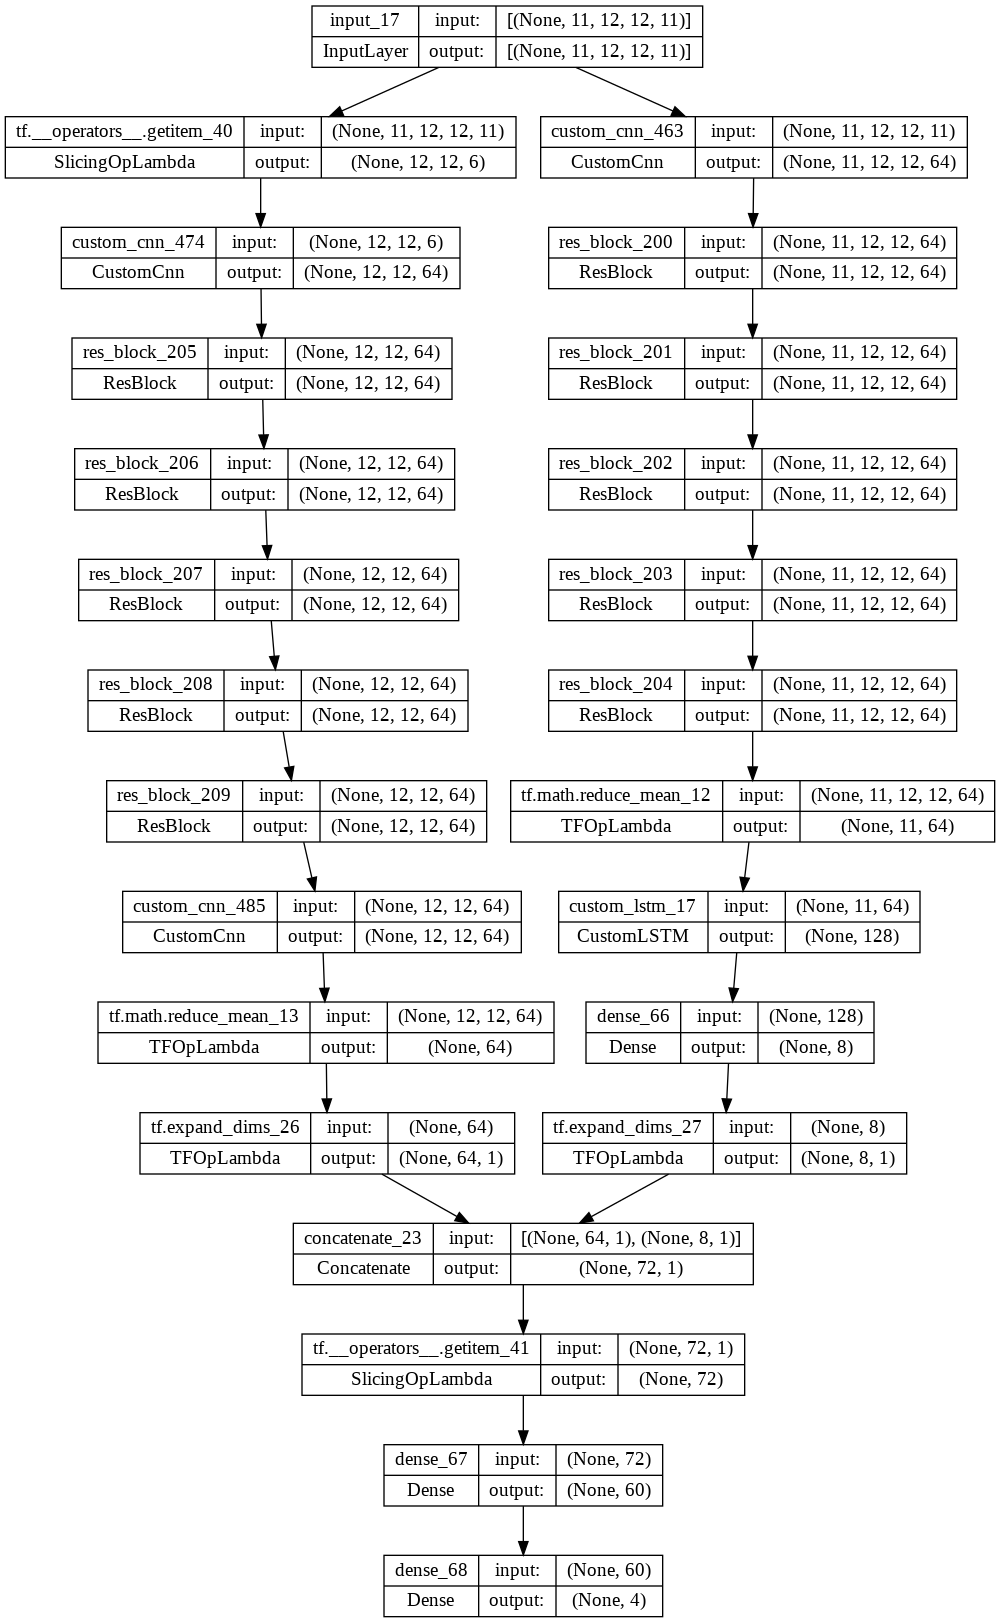

In [145]:
tf.keras.utils.plot_model(plot_model.model(), show_shapes=True)

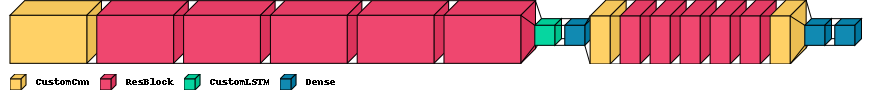

In [146]:
import visualkeras
visualkeras.layered_view(plot_model, legend=True, draw_volume=True)

In [147]:
import tensorflow as tf
from datetime import datetime
import tensorboard

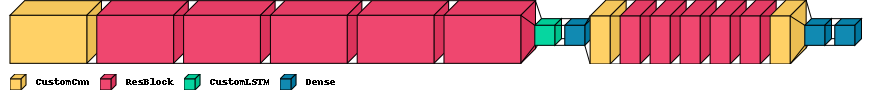

In [148]:
visualkeras.layered_view(plot_model,legend=True, draw_volume=True)

In ToMnet-N: 
input_trajectory:  (None, 10, 12, 12, 11)
input_current_state:  (None, 12, 12, 6)
e_char:  (None, 8)
input_current_state:  (None, 12, 12, 8)
e_char:  (None, 1, 8)
e_char:  (None, 1, 1, 8)
e_char:  (None, 1, 12, 8)
pred input:  (None, 13, 12, 8)


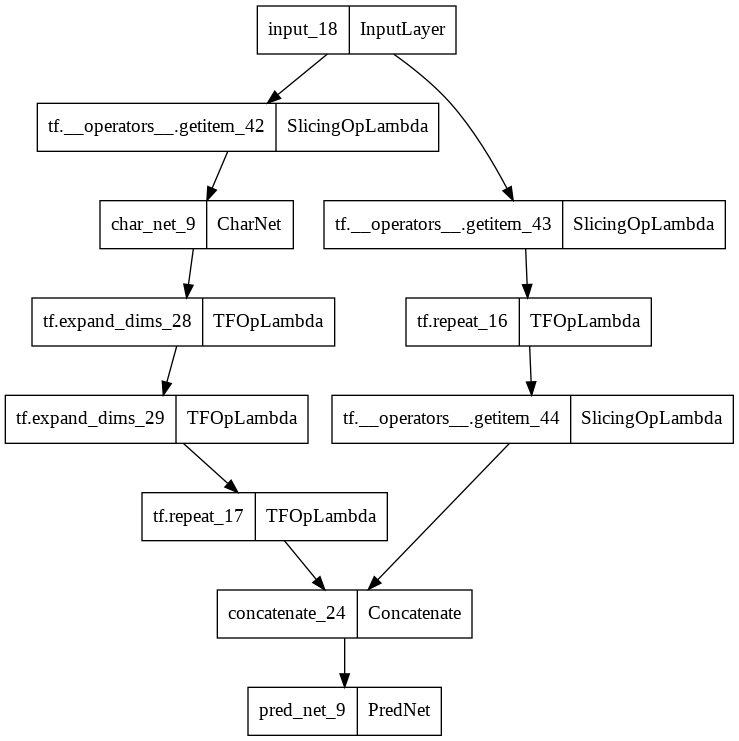

In [149]:
tf.keras.utils.plot_model(ToMnet_N.model())

## Define CharNet for plot

In [150]:
## Recreate CharNet and PredNet as models to make plotting:
# --------------------------------------------------------------
# CharNet is a layer, as it doesn't have separate and own training,
# it is simply a part of whole network, so can be considered as a layer
# --------------------------------------------------------------
class CharNetModel(Model):

    def __init__(self, input_tensor, n, N_echar):
        super(CharNetModel, self).__init__()

        # self.input_tensor = input_tensor
        self.n = n
        self.N_echar = N_echar

        self.conv = CustomCnnCharNet(input_tensor=input_tensor)
        self.res_blocks = [None] * n
        for i in range(n):
          self.res_blocks[i] = ResBlockCharNet()
        # Global Pool
        self.lstm = CustomLSTM()
        self.e_char = Dense(N_echar)
        

    def call(self, inputs):
        """
        Build the character net.
        """

        # input_tensor = self.input_tensor
        n = self.n
        N_echar = self.N_echar

        batch_size, trajectory_size, height, width, depth  = inputs.get_shape().as_list()

        # --------------------------------------------------------------
        # Paper codes
        # (16, 10, 12, 12, 11) -> (16, 10, 12, 12, 32)
        # Add initial Conv2D layer
        # Conv2D standard: Shape = (batch_size, width, height, channels)
        # Conv2D takes only width x height x channels (12, 12, 11)
        # Time Distributed layer feeds a Conv2D with time-frames (10 frames)
        # That process is happening in parallel for 16 objects in one batch
        # --------------------------------------------------------------
        x = self.conv(inputs)

        # --------------------------------------------------------------
        # Paper codes
        # (16, 10, 12, 12, 11) -> (16, 10, 12, 12, 32)
        # Add n residual layers
        # Conv2D takes only width x height x channels (12, 12, 11)
        # Time Distributed layer feeds a Conv2D with time-frames (10 frames)
        # That process is happening in parallel for 16 objects in one batch
        # --------------------------------------------------------------
        for i in range(n):
          x = self.res_blocks[i](x)    ### Possible error here!!!
            
        # --------------------------------------------------------------
        # Paper codes
        # (16, 10, 12, 12, 32) ->  (16, 10, 32)
        # Add average pooling
        # Collapse the spatial dimensions
        # --------------------------------------------------------------
        x = tf.reduce_mean(input_tensor=x, axis=[2, 3])

        # --------------------------------------------------------------
        # Paper codes
        # (16, 10, 32) ->  (16, 64)
        # Add LSTM
        # Standard: Shape = (batch_size, time_step, features)
        # for each x_i(t)(example_i's step_t): a (64, 1) = W(64, 32) * x (32, 1)
        # --------------------------------------------------------------
        x = self.lstm(x)

        # --------------------------------------------------------------
        # Paper codes
        # (16, 64) -> (16, 4)
        # Add Fully connected layer
        # (batch_size, features) - > (batch_size, e_char)
        # --------------------------------------------------------------
        x = self.e_char(x)

        return x

    ### This is a trick to view shapes in summary() via
    ### model.model().summary()
    def model(self):
        x = tf.keras.Input(shape=(11, 12, 12, 11))
        return tf.keras.Model(inputs=[x], outputs=self.call(x))


In [151]:
CharNet = CharNetModel((10, 12, 12, 11), 5, 8)

In [152]:
CharNet.build((16, 10, 12, 12, 11))

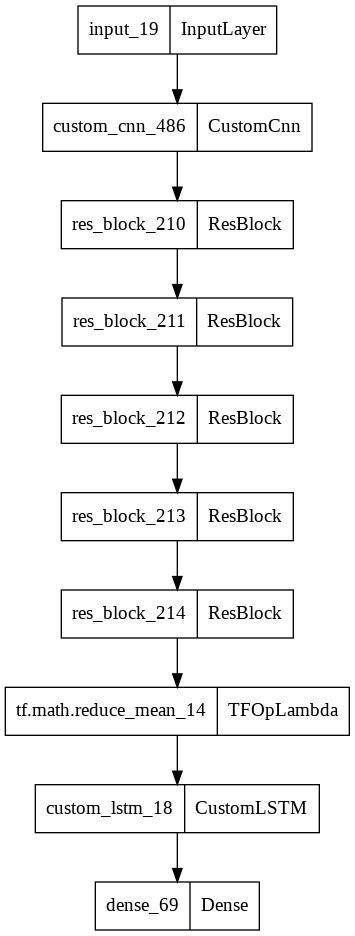

In [153]:
tf.keras.utils.plot_model(CharNet.model())

## Define PredNet for plot


In [157]:
# --------------------------------------------------------------
# PredNet is a layer, as it doesn't have separate and own training,
# it is simply a part of whole network, so can be considered as a layer
# --------------------------------------------------------------
class PredNetModel(Model):

    def __init__(self, n):
        super(PredNetModel, self).__init__()
        self.n = n

        self.e_char_shape = 8
        self.current_state_shape = (12, 12, 6)


        self.input_layer = tf.keras.Input(shape=(13, 12, 6), name="Input Layer")
        self.conv_1 = CustomCnnPredNet(input_tensor=self.current_state_shape, name="Conv1")
        self.res_blocks = [None] * n
        for i in range(n):
          self.res_blocks[i] = ResBlockPredNet(name="ResBlock" + str(i))
        self.conv_2 = CustomCnnPredNet(activation='relu', name="Conv2")
        self.fc1 = Dense(units=128, activation=activations.relu, name="Dense1")
        self.fc2 = Dense(units=128, activation=activations.relu, name="Dense2")
        self.fc3 = Dense(units=64, activation=activations.relu, name="Dense3")
        # drop_out_1 = Dropout(rate = 0.2) ### Could be added in the future
        self.goal_predict = Dense(units=4, activation=activations.linear)

    def call(self, inputs):
        """
        Build the character net.
        """
        ### Check that inputs.shape == (None, 13, 12, 8)

        # Get shapes
        # batch_size, height, width, depth = inputs.get_shape().as_list()
        # _, embedding_length = e_char.get_shape().as_list()
        n = self.n

        # --------------------------------------------------------------
        # Paper codes
        # (16, 13, 12, 8) -> (16, 12, 12, 6) + (16, 8)
        # Decompose input data
        # Initially in is a mix of Current State and e_char embedding space
        # --------------------------------------------------------------
        input_current_state = inputs[..., 0:12, 0:12, 0:6]
        e_char = inputs[..., 12, 0, :]

        print("Original Input: ", inputs.shape)
        print("input_current_state: ", input_current_state.shape)
        print("e_char: ", e_char.shape)

        # --------------------------------------------------------------
        # Paper codes
        # (16, 12, 12, 6) -> (16, 12, 12, 32)
        # Use 3x3 conv layer to shape the depth to 32
        # to enable resnet to work (addition between main path and residual connection)
        # --------------------------------------------------------------
        x = self.conv_1(input_current_state)

        # --------------------------------------------------------------
        # Paper codes
        # (16, 12, 12, 32) -> (16, 12, 12, 32)
        # Add n residual layers
        # Conv2D takes only width x height x channels (12, 12, 11)
        # Time Distributed layer feeds a Conv2D with time-frames (10 frames)
        # That process is happening in parallel for 16 objects in one batch
        # --------------------------------------------------------------
        for i in range(n):
          x = self.res_blocks[i](x)    ### Possible error here!!!

        # --------------------------------------------------------------
        # Paper codes
        # (16, 12, 12, 32) -> (16, 12, 12, 32)
        # Add CNN after Res Blocks
        # --------------------------------------------------------------
        x = self.conv_2(x)

        # --------------------------------------------------------------
        # Paper codes
        # (16, 12, 12, 32) -> (16, 32)
        # Add average pooling
        # Collapse the spatial dimensions
        # --------------------------------------------------------------
        x = tf.reduce_mean(input_tensor=x, axis=[1, 2])

        # --------------------------------------------------------------
        # Paper codes
        # (16, 32) + (16, 8) -> (16, 32, 1) + (16, 8, 1) - > 
        # (16, 40, 1) -> (16, 40)
        # Concatenate tensor with e_char
        # Concatenation requires a common dimentions which cannot be a batch
        # --------------------------------------------------------------
        x = tf.expand_dims(x, axis=-1)
        e_char = tf.expand_dims(e_char, axis=-1)

        x = tf.keras.layers.Concatenate(axis=1)([x, e_char])
        x = x[..., 0]

        # --------------------------------------------------------------
        # Paper codes
        # (16, 40) -> (16, 60) -> (16, 4)
        # Fully connected layer with dropout for regularization
        # --------------------------------------------------------------
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        x =  self.goal_predict(x)

        return x

    ### This is a trick to view shapes in summary() via
    ### model.model().summary()
    def model(self):
        x = tf.keras.Input(shape=(13, 12, 8))
        return tf.keras.Model(inputs=[x], outputs=self.call(x))

In [158]:
PredNetm = PredNetModel(8)
dummy_data = tf.ones((16, 13, 12, 8))
PredNetm.predict(dummy_data)

Original Input:  (None, 13, 12, 8)
input_current_state:  (None, 12, 12, 6)
e_char:  (None, 8)
Original Input:  (None, 13, 12, 8)
input_current_state:  (None, 12, 12, 6)
e_char:  (None, 8)
1/1 [==============================] - 1s 1s/step


array([[ 0.02931182, -0.0170868 , -0.03753139,  0.27344117],
       [ 0.02931182, -0.0170868 , -0.03753139,  0.27344117],
       [ 0.02931182, -0.0170868 , -0.03753139,  0.27344117],
       [ 0.02931182, -0.0170868 , -0.03753139,  0.27344117],
       [ 0.02931182, -0.0170868 , -0.03753139,  0.27344117],
       [ 0.02931182, -0.0170868 , -0.03753139,  0.27344117],
       [ 0.02931182, -0.0170868 , -0.03753139,  0.27344117],
       [ 0.02931182, -0.0170868 , -0.03753139,  0.27344117],
       [ 0.02931182, -0.0170868 , -0.03753139,  0.27344117],
       [ 0.02931182, -0.0170868 , -0.03753139,  0.27344117],
       [ 0.02931182, -0.0170868 , -0.03753139,  0.27344117],
       [ 0.02931182, -0.0170868 , -0.03753139,  0.27344117],
       [ 0.02931182, -0.0170868 , -0.03753139,  0.27344117],
       [ 0.02931182, -0.0170868 , -0.03753139,  0.27344117],
       [ 0.02931182, -0.0170868 , -0.03753139,  0.27344117],
       [ 0.02931182, -0.0170868 , -0.03753139,  0.27344117]],
      dtype=float32)

Original Input:  (None, 13, 12, 8)
input_current_state:  (None, 12, 12, 6)
e_char:  (None, 8)


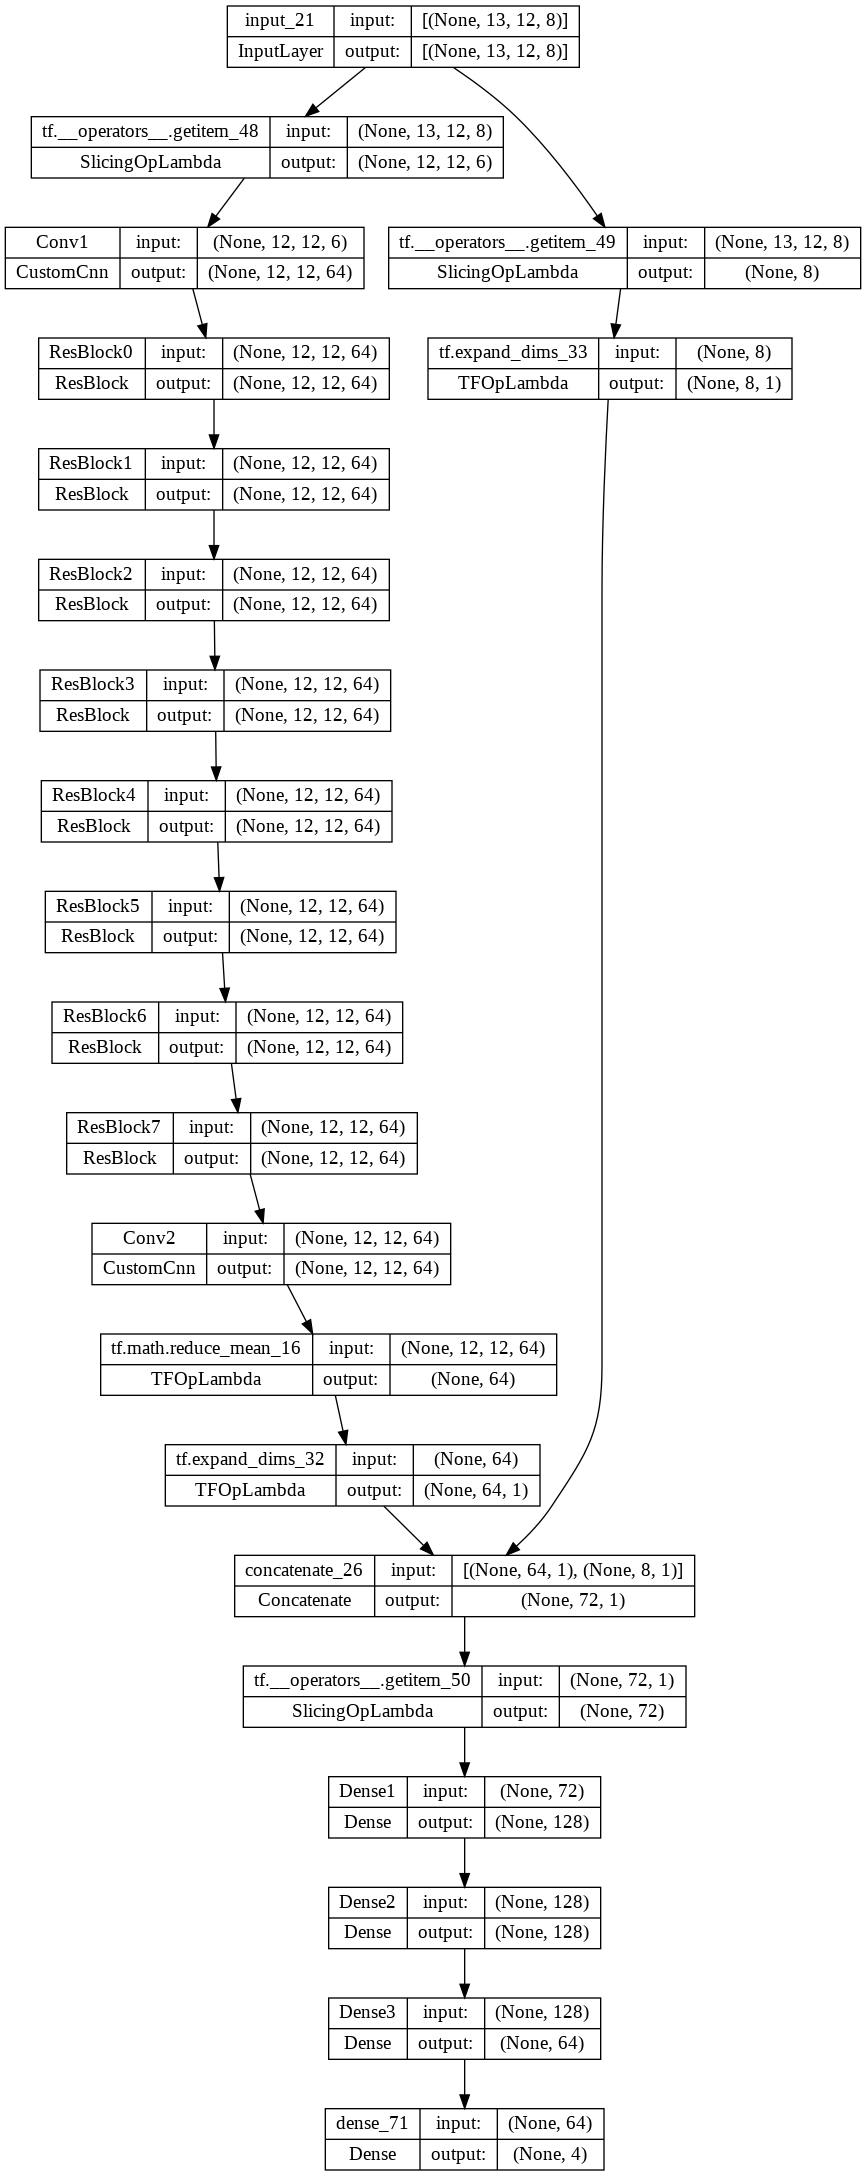

In [159]:
tf.keras.utils.plot_model(PredNetm.model(), show_shapes=True)

In [160]:
input_trajectory = dummy_combined[0:10,:,:,:]
input_current_state = dummy_combined[10,:,:,0:6]

print("input_trajectory: ", input_trajectory.shape)
print("input_current_state: ", input_current_state.shape)

input_trajectory:  (10, 11, 12, 12, 11)
input_current_state:  (11, 12, 6, 11)


In [161]:
print(dummy_combined.shape)

(16, 11, 12, 12, 11)


In [162]:
e_char = tf.ones((8))
dummy_data_2 = tf.ones((12, 12, 6))

e_char_2 =  tf.expand_dims(e_char, axis=0)
e_char_2 =  tf.expand_dims(e_char_2, axis=0)
e_char_2 = tf.repeat(e_char_2, repeats=12, axis=1)

dummy_data_2 = tf.repeat(dummy_data_2, repeats=2, axis=-1)
dummy_data_2 = dummy_data_2[..., 0:8]

mix_data = tf.keras.layers.Concatenate(axis=0)([e_char_2, dummy_data_2])

print("dummy_data_2: ", dummy_data_2.shape)
print("e_char: ", e_char.shape)
print("e_char_2: ", e_char_2.shape)
print("mix_data: ", mix_data.shape)

dummy_data_2:  (12, 12, 8)
e_char:  (8,)
e_char_2:  (1, 12, 8)
mix_data:  (13, 12, 8)


In [163]:
e_char = mix_data[12,0,:]
input_current_state = mix_data[0:12,:,0:6]

print(e_char.shape)
print(input_current_state.shape)

(8,)
(12, 12, 6)


In [164]:
PredNetm.summary()

Model: "pred_net_model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Conv1 (CustomCnn)           (None, 12, 12, 64)        3520      
                                                                 
 ResBlock0 (ResBlock)        (None, 12, 12, 64)        73856     
                                                                 
 ResBlock1 (ResBlock)        (None, 12, 12, 64)        73856     
                                                                 
 ResBlock2 (ResBlock)        (None, 12, 12, 64)        73856     
                                                                 
 ResBlock3 (ResBlock)        (None, 12, 12, 64)        73856     
                                                                 
 ResBlock4 (ResBlock)        (None, 12, 12, 64)        73856     
                                                                 
 ResBlock5 (ResBlock)        (None, 12, 12, 64)   

In [165]:
CharNet.summary()

Model: "char_net_model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 custom_cnn_486 (CustomCnn)  (None, 11, 12, 12, 64)    6400      
                                                                 
 res_block_210 (ResBlock)    (None, 11, 12, 12, 64)    73856     
                                                                 
 res_block_211 (ResBlock)    (None, 11, 12, 12, 64)    73856     
                                                                 
 res_block_212 (ResBlock)    (None, 11, 12, 12, 64)    73856     
                                                                 
 res_block_213 (ResBlock)    (None, 11, 12, 12, 64)    73856     
                                                                 
 res_block_214 (ResBlock)    (None, 11, 12, 12, 64)    73856     
                                                                 
 custom_lstm_18 (CustomLSTM)  (None, 128)         